# Initialize

In [1]:
from ray.tune import ResultGrid
from ray import tune, air

import pickle, os, sys

import numpy as np
import random

from librosa import zero_crossings, power_to_db
from librosa.feature import melspectrogram, mfcc

from deap import creator, gp, base, tools
import librosa

import yaml

import matplotlib.pyplot as plt
import pygraphviz as pgv
plt.ion()

from ipywidgets import interactive, interact
import ipywidgets as widgets
import IPython.display as ip_disp
from  IPython.display import HTML

# Necessary to be able to import code from the main Python files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from gensynth.supercollider.representation import get_primitive_set, available_ugens
from gensynth.supercollider.synthesis import initialize_synthesis_dirs, synthesize_sounds
from gensynth.supercollider.fitness import reevaluate_individuals
from gensynth.genetic_algorithm import run_genetic_algorithm

initialize_synthesis_dirs()

2023-07-31 10:20:18.809994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-31 10:20:18.810041: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
primitive_set = get_primitive_set()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, pset=primitive_set)

toolbox = base.Toolbox()
toolbox.register(
    "generateSynthTree",
    gp.genGrow,
    pset=primitive_set,
    min_=1,
    max_=3
)

# Create an individual generating function that is a synth definition tree
toolbox.register("individual", tools.initIterate, container=creator.Individual, generator=toolbox.generateSynthTree)

# Create a population function that generates a list of n individuals using the individual() function.
toolbox.register("population", tools.initRepeat, container=list, func=toolbox.individual)

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
%matplotlib ipympl

In [5]:
config_directory = '../logs/ray_results/'
config_files = sorted(os.listdir(config_directory))

config_widget = widgets.Dropdown(options=config_files, description='Run:', value=None)

def reload_configs(event):
    config_files = sorted(os.listdir(config_directory))
    config_widget.options = config_files

reload_widget = widgets.Button(description='Reload')
reload_widget.on_click(reload_configs)

display(widgets.HBox([reload_widget, config_widget]))

In [96]:
experiment_path = '../logs/ray_results/' + config_widget.value
print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable=run_genetic_algorithm)
result_grid = restored_tuner.get_results()

2023-07-31 10:39:17,318	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is periodic.


Loading results from ../logs/ray_results/genetic_algorithm_trial_2023_07_31__06:39...


In [97]:
if result_grid.errors:
    print("One of the trials failed!")
else:
    print("No errors!")

num_results = len(result_grid)
print("Number of results:", num_results)

No errors!
Number of results: 293


array([[<AxesSubplot: title={'center': 'best_fitness'}>]], dtype=object)

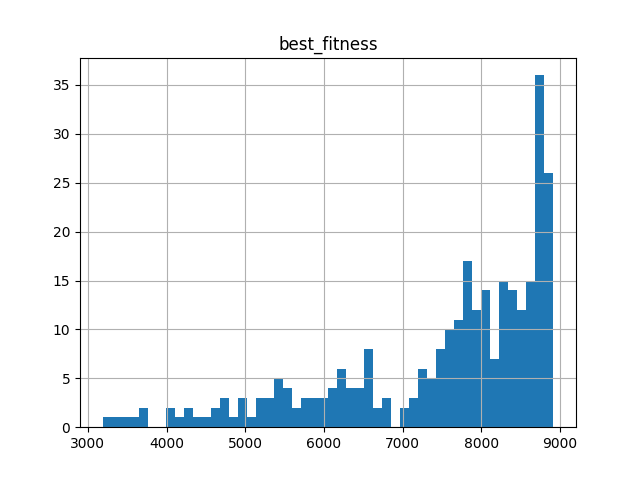

In [98]:
results_df = result_grid.get_dataframe()
results_df[["best_fitness"]].hist(bins=50)

Text(0, 0.5, 'Best Fitness')

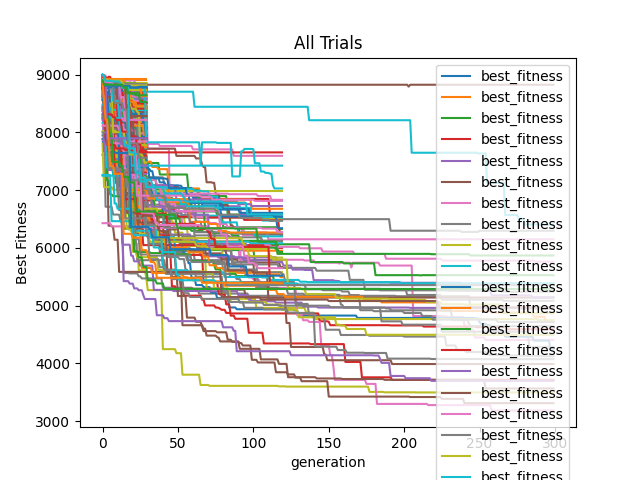

In [99]:
ax = None
for result in result_grid:
    #label = f"lr={result.config['lr']:.3f}, momentum={result.config['momentum']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("generation", "best_fitness")
    else:
        if result.metrics_dataframe is not None:
            result.metrics_dataframe.plot("generation", "best_fitness", ax=ax)
ax.set_title("All Trials")
ax.set_ylabel("Best Fitness")

In [100]:
results_df.head()

generation  best_fitness  \
0          29   8141.554688   
1         119   6114.458984   
2          29   8279.323242   
3          29   8819.811523   
4           7   8833.458984   

                                     best_individual  time_this_iter_s   done  \
0  mul(sub(BrownNoiseKR(), PulseAR(5251.0, 13407....          0.887207   True   
1  mul(BrownNoiseKR(), SinOscAR(BRFKR(7741.0, 3.5...          1.095899   True   
2                    SinOscAR(411.0, BrownNoiseKR())          0.601326   True   
3                                     BrownNoiseKR()          0.640015   True   
4                                     BrownNoiseKR()          1.111565  False   

   training_iteration  trial_id                 date   timestamp  \
0                  30  01d015ce  2023-07-31_07-19-54  1690780794   
1                 120  01d72673  2023-07-31_07-44-28  1690782268   
2                  30  022974b2  2023-07-31_06-42-57  1690778577   
3                  30  035c4441  2023-07-31_07-51-07  1690782667   
4                   8  040bb836  2023-07-31_08-27-23  1690784843   

   time_total_s  ...  \
0     30.409996  ...   
1    121.815039  ...   
2     20.408366  ...   
3     23.215639  ...   
4     10.059782  ...   

   config/evolutionary_algorithm/selection/hall_of_fame_size  \
0                                                  5           
1                                                  5           
2                                                  5           
3                                                  5           
4                                                  5           

  config/evolutionary_algorithm/selection/scheme  \
0                         rank_double_tournament   
1                         rank_double_tournament   
2                         rank_double_tournament   
3                         rank_double_tournament   
4                         rank_double_tournament   

  config/evolutionary_algorithm/selection/size_tournament_size  \
0                                                1.3             
1                                                1.2             
2                                                1.6             
3                                                1.6             
4                                                1.1             

   config/jax/lifetime_learning/gradient_descent_steps  \
0                                                200     
1                                                200     
2                                                200     
3                                                200     
4                                                200     

   config/jax/lifetime_learning/individual_count  \
0                                             10   
1                                             10   
2                                             10   
3                                             10   
4                                             10   

   config/jax/lifetime_learning/initial_learning_rate  \
0                                               5e-4    
1                                               5e-4    
2                                               5e-4    
3                                               5e-4    
4                                               5e-4    

  config/evolutionary_algorithm/genetic_programming/tree_depth/max  \
0                                                 17                 
1                                                 17                 
2                                                 17                 
3                                                 17                 
4                                                 17                 

   config/evolutionary_algorithm/genetic_programming/tree_depth/initial/max  \
0                                                  3                          
1                                                  3                          
2                

In [101]:
best_result = result_grid.get_best_result()
print(best_result.metrics["best_fitness"])

3186.35009765625


In [102]:
best_result.metrics["best_individual"]

'BRFAR(SinOscAR(sub(BPFAR(BPFAR(5515.0, BRFKR(3.8143920455137974, SinOscKR(4.571146414771977, 5895.0), 3.8263507432564348), BPFAR(0.12423599214113346, sub(mul(4.792628001000674, 3.8944753700758956), 1.1125135496782446), 1.222741520281141)), BPFAR(mul(add(0.06092682894957846, 0.2910368017580489), 1.9714671895773628), 2.7039113447161833, 3929.0), BRFAR(mul(2.8667650247299887, 3.422286995079814), 5298.0, 14304.0)), PulseKR(0.7076161523480623, mul(add(4.139336722013178, 0.7076161523480623), 3.742959328340411))), add(sub(mul(0.8216340661837074, 1.525277563119161), SinOscKR(5789.0, BPFAR(SinOscAR(0.16450776384037913, mul(2554.0, 1.060882860531966)), 3.802711047170779, 3412.0))), 3.5015316372445215)), sub(15068.0, 11103.0), add(0.8822766176214281, 1.5707603808613606))'

In [103]:
from supriya import SynthDefBuilder, CalculationRate
from supriya.ugens import Out, K2A
import numbers

duration = 0.1
sample_rate = 44100

def synth_expr_to_synth_def(synth_expr, index, primitive_set):
    builder = SynthDefBuilder()
    with builder:
        synth_out = eval(
            synth_expr,
            primitive_set.context,
            {}
        )

        # Stopgap to avoid piping something that is just a constant into Out.ar, which causes a SC segfault
        if isinstance(synth_out, numbers.Number):
            return None

        # Convert a control rate root node to audio rate to avoid a segfault
        if synth_out.calculation_rate == CalculationRate.CONTROL:
            synth_out = K2A.ar(source=synth_out)

        # Direct each synth to its own output bus
        Out.ar(bus=index, source=synth_out)

    return builder.build(name="synth_" + str(index))


def individual_to_sound(
    individual,
    primitive_set,
    duration,
    sampling_rate,
    temporary_path="/tmp/synthesis/",
    sc_executable_path="../SuperCollider/installation/bin/scsynth"
):
    # Convert the individual trees to synth definitions (or None, for invalid individuals)
    synth_definition = synth_expr_to_synth_def(individual, 0, primitive_set)
    
    output_audio, exit_code = synthesize_sounds(
        # Filter out all invalid synth defs
        [synth_definition],
        duration,
        channel_count=1,
        sampling_rate=sampling_rate,
        temporary_path=temporary_path,
        sc_executable_path=sc_executable_path
    )

    if exit_code != 0:
        print("Error: Synthesis produced exit code " + str(exit_code))
        print("Synths:")
        [print(str(synth)) for synth in synth_definitions]
        exit(1)

    # Add the individual dimension even if the audio itself only contains one
    if len(output_audio.shape) == 1:
        output_audio = np.expand_dims(output_audio, 0)

    return output_audio

def display_solution(individual):

    audio = individual_to_sound(individual,primitive_set, duration, sample_rate, sc_executable_path="../SuperCollider/installation/bin/scsynth")

    solution_widget = widgets.Output()
    with solution_widget:
        audio_widget = ip_disp.Audio(
            data=audio, 
            rate=sample_rate
        )
        display(audio_widget)
        
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_spectrogram_decibel = librosa.power_to_db(mel_spectrogram, ref=np.max)
        figure, ax = plt.subplots()
        img = librosa.display.specshow(
            mel_spectrogram_decibel[0],
            x_axis='time',
            y_axis='mel',
            sr=sample_rate,
            fmax=8000,
            ax=ax
        )
        figure.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.tight_layout()
        ax.set(title='Mel-frequency spectrogram')
        plt.show()
            

    display(solution_widget)

display_solution(best_result.metrics["best_individual"])

Output()

In [104]:
label_audio_name = best_result.config['target_audio']['name']
label_audio_path = "../sounds/" + label_audio_name + ".aiff"
label_audio, _ = librosa.load(label_audio_path, sr=sample_rate)

audio_widget = ip_disp.Audio(
    data=label_audio, 
    rate=sample_rate
)
display(audio_widget)

mel_spectrogram_label = librosa.feature.melspectrogram(y=label_audio, sr=sample_rate)
mel_spectrogram_decibel_label = librosa.power_to_db(mel_spectrogram_label, ref=np.max)
figure, ax = plt.subplots()
img = librosa.display.specshow(
    mel_spectrogram_decibel_label,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=8000,
    ax=ax
)
figure.colorbar(img, ax=ax, format='%+2.0f dB')
plt.tight_layout()
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [105]:
best_config = best_result.config
print(yaml.dump(best_config))

__trial_index__: 3
evolutionary_algorithm:
  early_stopping: 1000
  fitness_function:
    distance: l1
    feature: mel_db
  generation_count: 300
  genetic_programming:
    tree_depth:
      initial:
        max: 3
        min: 1
      max: 17
  operators:
    crossover:
    - one_point
    - merge
    - merge_arithmetic
    crossover_probability: 0.1
    mutation:
    - insert
    mutation_probability: 0.5
  population_size: 500
  selection:
    fitness_tournament_size: 14
    hall_of_fame_size: 5
    scheme: rank_double_tournament
    size_tournament_size: 1.1
jax:
  lifetime_learning:
    gradient_descent_steps: 200
    individual_count: 10
    initial_learning_rate: 5e-4
  parameter_count: 5
  simulated_binary_crossover_eta: 2
  use_jax_implementation: false
log_mode: tune
multi_objective:
  helper_objective: zero_crossings
  nd_rank_double_tournament_selection: true
  zero_crossings_histogram_bin_count: 30
supercollider:
  eph_mode: one
target_audio:
  name: synthetic/multiple_os